## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from transformers import BertTokenizer, BertModel
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix



/home/henrique/anaconda3/envs/nlp2/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load and preprocess data

In [2]:
def load_data(text_file):

    with open(text_file, encoding="utf-8") as file:
        sentences = []
        for line in file:
            if line != '\n':
                tuples = []
                for word in line.split():
                    w, tag = word.split('_')
                    tuples.append((w,tag))            
                sentences.append(tuples)
        
        return sentences

In [3]:
train_data = load_data(text_file="data/macmorpho-v3/macmorpho-train.txt")
test_data = load_data(text_file="data/macmorpho-v3/macmorpho-test.txt")

In [4]:
num_words = 0
num_tags = 0
words_set = set()
tags_set = set()
tag_count = {}

for sentence in train_data:
    for word, tag in sentence:
        words_set.add(word)
        tags_set.add(tag)
        
        if tag in tag_count:
            tag_count[tag] += 1
        else:
            tag_count[tag] = 1

print("Dados de treinamento")
print(f"Número de frases: {len(train_data)}")
print(f"Tamanho do vocabulário: {len(words_set)}")
print(f"Número de tags: {len(tags_set)}")

Dados de treinamento
Número de frases: 37948
Tamanho do vocabulário: 52759
Número de tags: 26


#### Histogram of frequency of each tag on training data

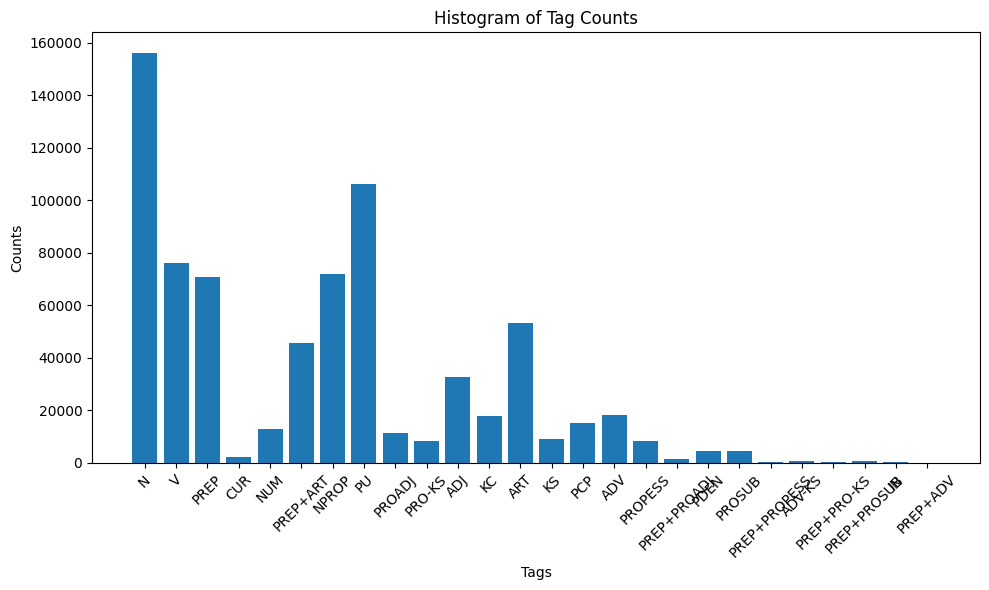

In [5]:
tags = list(tag_count.keys())
counts = list(tag_count.values())

# Create the histogram
plt.figure(figsize=(10, 6))
plt.bar(tags, counts)
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.title('Histogram of Tag Counts')
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

In [6]:
num_words = 0
num_tags = 0
words_set = set()
tags_set = set()


for sentence in test_data:
    for word, tag in sentence:
        words_set.add(word)
        tags_set.add(tag)

print("Dados de teste")
print(f"Número de frases: {len(test_data)}")
print(f"Tamanho do vocabulário: {len(words_set)}")
print(f"Número de tags: {len(tags_set)}")

Dados de teste
Número de frases: 9987
Tamanho do vocabulário: 25140
Número de tags: 26


In [7]:
tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased", torch_dtype=torch.float16)
tokenizer

BertTokenizer(name_or_path='google-bert/bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [8]:
tags.append("<pad>")

tag2idx = {tag:idx for idx, tag in enumerate(tags)}
idx2tag = {idx:tag for idx, tag in enumerate(tags)}

## Pytorch dataset

The `PosDataset` class is a custom dataset for POS tagging tasks, tailored for use with BERT. It handles the preprocessing of input sentences and their corresponding tags, preparing them for input into a BERT model.

#### **`PosDataset`**:
  - Inherits from `torch.utils.data.Dataset` and initializes with a list of tagged sentences, a BERT tokenizer, and mappings between tags and indices.
  - Tokenizes the words in the sentence, while handling special tokens `[CLS]` and `[SEP]`.
  - Creates masks to identify the head of each word (to align with subword tokenization used by BERT).
  - Converts words and tags to their corresponding token IDs and indices.

This implementation ensures that the data is appropriately formatted for input into a BERT model for POS tagging, handling the complexities of subword tokenization and special token management.


In [9]:
class PosDataset(Dataset):

    """A custom dataset class for POS tagging using BERT tokenizer""" 

    def __init__(self, tagged_sentences, tokenizer: BertTokenizer, tag2idx, idx2tag):
        """Initializes the PosDataset instance.""" 
        
        sentences = []
        tags= []
        self.tokenizer = tokenizer
        self.tag2idx = tag2idx
        self.idx2tag = idx2tag
        self.max_seqlen = 0

        for sentence in tagged_sentences:
            words = [word_tag_tuple[0] for word_tag_tuple in sentence]
            sentence_tags = [word_tag_tuple[1] for word_tag_tuple in sentence]
            sentences.append(["[CLS]"] + words + ["[SEP]"])
            tags.append(["<pad>"] + sentence_tags + ["<pad>"])

        self.sentences = sentences
        self.tags = tags

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):

        words, tags = self.sentences[idx], self.tags[idx]
        
        X, y = [], []

        word_head_masks = []
        for w, t in zip(words, tags):

            if w not in ["[CLS]", "[SEP]"]:
                tokens = self.tokenizer.tokenize(w)
            else:
                tokens = [w]
            
            word_ids = self.tokenizer.convert_tokens_to_ids(tokens)
            
            word_head_mask = [1] + [0]*(len(tokens) - 1)
            t = [t] + ["<pad>"] * (len(tokens) - 1) 

            tags_idx = [self.tag2idx[tag] for tag in t]

            X.extend(word_ids)
            word_head_masks.extend(word_head_mask)
            y.extend(tags_idx)

        seqlen = len(y)

        words = " ".join(words)
        tags = " ".join(tags)
        return words, X, word_head_masks, tags, y, seqlen




In [10]:
pos_train_dataset = PosDataset(train_data, tokenizer, tag2idx, idx2tag)
pos_test_dataset = PosDataset(test_data, tokenizer, tag2idx, idx2tag)

### Creating Pytorch Data Loader

#### Collate Function for padding

The `collate_function` is used to batch and pad sequences for the Dataloader

In [11]:
def collate_function(batch):

    words = [sample[0] for sample in batch]
    is_heads = [sample[2] for sample in batch]
    tags = [sample[3] for sample in batch]
    seqlens = [sample[-1] for sample in batch]

    maxlen = max(seqlens)

    f = lambda x, seqlen: [sample[x] + [0] * (seqlen - len(sample[x])) for sample in batch]
    x = f(1, maxlen)
    y = f(-2, maxlen)

    return words, torch.LongTensor(x), is_heads, tags, torch.LongTensor(y), seqlens

#### DataLoader Setup

Create two DataLoaders for training and testing datasets, using the `collate_function` above

In [12]:
train_dataloader = DataLoader(dataset=pos_train_dataset,
                            batch_size=8,
                            shuffle=True,
                            num_workers=4,
                            collate_fn=collate_function)
test_dataloader = DataLoader(dataset=pos_test_dataset,
                            batch_size=8,
                            shuffle=False,
                            num_workers=4,
                            collate_fn=collate_function)

In [13]:
print( "Number of train batches",len(train_dataloader))
print( "Number of test batches",len(test_dataloader))

Number of train batches 4744
Number of test batches 1249


## Fine-Tuned BERT Model

This model is a fine-tuned version of the BERT (Bidirectional Encoder Representations from Transformers) model. It consists of a pre-trained BERT model followed by a linear layer for classification.

#### Model Structure:
- **BERT Backbone**: The core of the model is the pre-trained BERT, which processes the input text and generates contextualized word embeddings.
- **Linear Layer**: A fully connected linear layer maps the BERT output to the desired number of labels for classification.

#### Forward Pass:
- The input text is passed through the BERT model to generate contextual embeddings.
- Depending on whether the model is in training or evaluation mode, it uses appropriate techniques to handle gradients.
- The embeddings from BERT are then passed through the linear layer to produce the final classification logits.
- The model outputs both the logits and the predicted labels (by taking the index of the maximum logit).

This architecture allows leveraging BERT's powerful language understanding while fine-tuning it for specific downstream tasks.

In [14]:
class FineTunedBert(nn.Module):
    def __init__(self, num_labels = None):
        super().__init__()

        self.bert = BertModel.from_pretrained("google-bert/bert-base-uncased")

        self.fc1 = nn.Linear(self.bert.config.hidden_size, num_labels)
    
    def forward(self, x):

        if self.training:
            self.bert.train()
            outputs = self.bert(x)
            out = outputs.last_hidden_state
        
        else:
            self.bert.eval()
            with torch.no_grad():
                outputs = self.bert(x)
                out = outputs.last_hidden_state

        
        logits = self.fc1(out)
        pred = logits.argmax(-1)

        return logits, pred

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [16]:
model = FineTunedBert(num_labels=len(tag2idx))

In [17]:
model.to(device)

FineTunedBert(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise

## Training / Fine-tuning 

In [18]:
optimizer = Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
epochs = 1

In [19]:
for epoch in range(epochs):
    model.train()
    for i, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        words, x, is_head, tags, y, seqlens = batch

        x = x.to(device)
        y = y.to(device)

        logits, pred = model(x)

        logits = logits.view(-1, logits.shape[-1])
        y = y.view(-1)

        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        if i%100 == 0:
            print(f"Step: {i}, Loss: {loss.item()}")


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Step: 0, Loss: 3.3944528102874756
Step: 100, Loss: 0.2607802450656891
Step: 200, Loss: 0.14593550562858582
Step: 300, Loss: 0.0640871673822403
Step: 400, Loss: 0.12722937762737274
Step: 500, Loss: 0.08496376872062683
Step: 600, Loss: 0.11237926036119461
Step: 700, Loss: 0.0594511553645134
Step: 800, Loss: 0.09430037438869476
Step: 900, Loss: 0.06826753169298172
Step: 1000, Loss: 0.03670135512948036
Step: 1100, Loss: 0.05578017979860306
Step: 1200, Loss: 0.06300793588161469
Step: 1300, Loss: 0.1732475608587265
Step: 1400, Loss: 0.07329685986042023
Step: 1500, Loss: 0.07940932363271713
Step: 1600, Loss: 0.0692586898803711
Step: 1700, Loss: 0.0847729817032814
Step: 1800, Loss: 0.10757739096879959
Step: 1900, Loss: 0.05961187556385994
Step: 2000, Loss: 0.061720047146081924
Step: 2100, Loss: 0.05044160410761833
Step: 2200, Loss: 0.03383425250649452
Step: 2300, Loss: 0.01937815733253956
Step: 2400, Loss: 0.08198364078998566
Step: 2500, Loss: 0.08895033597946167
Step: 2600, Loss: 0.0347253195

## Testing

In [20]:
model.eval()  

predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        words, x, is_head, tags, y, seqlens = batch
        x = x.to(device)
        y = y.to(device)

        logits, pred = model(x)
        logits = logits.view(-1, logits.shape[-1])
        y = y.view(-1)

        pred_labels = logits.argmax(dim=-1)

        predictions.extend(pred_labels.cpu().numpy())
        true_labels.extend(y.cpu().numpy())

accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')

In [21]:
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")

Test Accuracy: 0.9847
Test Precision: 0.9848


### Measuring accuracy for each class

In [22]:
accuracy_dict = {}
total_dict = {}

for i, label in enumerate(predictions):
    tag = idx2tag[label]
    true_tag = idx2tag[true_labels[i]]
    if tag == true_tag:
        if tag in accuracy_dict:
            accuracy_dict[tag] +=1
        else:
            accuracy_dict[tag] = 0
    
    if true_tag in total_dict:
        total_dict[true_tag] +=1
    else:
        total_dict[true_tag] = 0

for tag in accuracy_dict:
    accuracy_dict[tag] = accuracy_dict[tag]/total_dict[tag]

In [23]:
for key in accuracy_dict:
    print(f"{key}: {accuracy_dict[key]}")

<pad>: 0.9992662000451569
N: 0.9931308052403922
ART: 0.981556562524843
ADJ: 0.9097392727697884
PREP+ART: 0.9595811313368565
PREP: 0.9813435059903439
NPROP: 0.8759334797615312
V: 0.967376966007103
PU: 0.9931606140579118
PRO-KS: 0.9567000911577028
PCP: 0.9480626545754328
KC: 0.9463576158940398
PROPESS: 0.969391304347826
ADV: 0.8730945821854913
PROADJ: 0.941193680514921
PDEN: 0.851512373968836
KS: 0.8052818289318092
PROSUB: 0.814176245210728
NUM: 0.9460629921259842
PREP+PROSUB: 0.7290322580645161
ADV-KS: 0.7205240174672489
PREP+PROADJ: 0.9837662337662337
PREP+PRO-KS: 0.8421052631578947
PREP+ADV: 0.7666666666666667
PREP+PROPESS: 0.896
IN: 0.44329896907216493
CUR: 0.9966101694915255


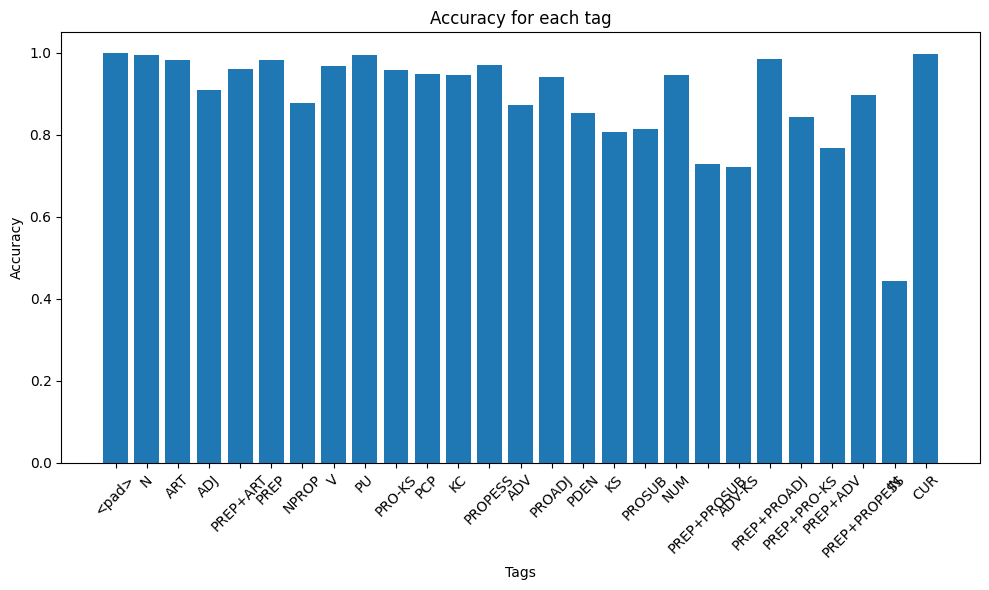

In [24]:
# Create the histogram
plt.figure(figsize=(10, 6))
plt.bar(accuracy_dict.keys(), accuracy_dict.values())
plt.xlabel('Tags')
plt.ylabel('Accuracy')
plt.title('Accuracy for each tag')
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

## Saving model

In [25]:
import os

if not os.path.isdir('model'):
    os.makedirs('model')

torch.save(model.state_dict(), "model/pytorch_model.bin")

## Loading model testing manually

In [26]:
model = FineTunedBert(27)

model.load_state_dict(torch.load("model/pytorch_model.bin", weights_only=True))

<All keys matched successfully>

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [28]:
def predict_sentence(sentence, model, tokenizer: BertTokenizer, device, tag2idx, idx2tag):
    """
    Predict the POS tag for a sentence using a fine-tuned BERT model.
    """

    model.eval()
    words = sentence.split()

    inputs = tokenizer(words, 
                       return_tensors='pt', 
                       truncation=True,
                       is_split_into_words=True,
                       padding=True).to(device)
    
    x = inputs['input_ids']
    x = x.to(device)

    logits, _ =  model(x)
    

    logits = logits.view(-1, logits.shape[-1])
    pred_labels = logits.argmax(dim=-1)

    pred_labels = pred_labels.cpu().numpy()
    
    pad_idx = tag2idx["<pad>"]

    return [idx2tag[t] for t in pred_labels if t != pad_idx]

In [29]:
word = 'O rato roeu a roupa do rei de Roma'
model.to(device)
predicted_tag = predict_sentence(word, model, tokenizer, device, tag2idx, idx2tag)
print(word)
print(predicted_tag)

O rato roeu a roupa do rei de Roma
['ART', 'N', 'V', 'ART', 'N', 'PREP+ART', 'N', 'PREP', 'NPROP']
